# Automated Generation of High Voltage Transistors and 3LFCC topology implementation

## Abstract
Our project focuses on designing and implementing high voltage re-sizable transistors for a DC-DC buck converter demonstrator based on the three-level flying capacitor converter (3LFCC) architecture, a simple but versatile type of flyingcapacitor multi-level (FCML) converter, using the Skywater 130nm CMOS technology (SKY130). This notebook shows the main steps of the analog design flow, namely simulation, layout, verification and post-layout simulation of a single and both converter cores based on the requirements that the user has given as input.


## 1. Introduction

Recent development in miniaturization of satellites have led to the widespread of the CubeSat standard. These applications have serious volume and weight restrictions and could greatly benefit from fully-integrating DC-DC converters, as they tend to be bulky and heavy. Figure 1 shows the different converters stages in the electronic power system of a CubeSat, where versatile topologies like FCML could prove to be convenient. High current density, reversibility and small passive devices are some of the major challenges. 

</br>

<div>
<img src="Images/EPS_.png" width="450"/>
</div>

</br> 

<center>Figure 1: Typical electronic power system (EPS) architecture of a CubeSat</center>

</br> 


Through this Notebook, it will be shown in simulation that a single converter core based on 3-L architecture can achieve high levels of efficiency at the targeted loads. It is worth noting that this simulation is considering an external passive filter and some inductances for representing the connections to the chip as such. The layout of the core is built using **.tcl** scripts.

## 2. Simulation and Device Generation

By using Python, this notebook generates a SPICE file to...

### 2.1 Understanding user input

The user just may give as input the desired output current and estimated area of use. This will output the minimum area given by the multiplicity necessary to manage the current output. Then, it will enlarge the devices to reach near the maximum area limit. With that, it will generate a file that will be used by the next code block to make a layout for the converter.

### 2.2 Converter Design

In [6]:
post_lay_sim_eff= 0
post_lay_dev_eff= 0

import numpy as np

alpha=float(input('Percentage of period for dead time: '))
alpha/=100
print(alpha)
v_ref=float(input('Output voltage in V: '))
freq=float(input('Operation frequency in MHz: '))
v_dc=5 #the level shifter is designed for a dc voltage output of 5V and a dc voltage input of 1.8V
dutycycle=round(1 - v_ref/v_dc,3)
period=round(1/freq,2)*1000
iout=float(input('Enter desired current output in mili-amperes (mA): '))

p_mult=0
n_mult=0
p_cell=0
n_cell=0
big=round(iout/1000, 5)
vdd=5
freq=1_000_000
guard_width=48
guard_offset_x=11.25
size=5.5


def lin_funct(m, a, b):
     return round(a*m + b,5) 

def cap_loss(cap, v, f):
     return round(cap*v*v*f,5) 

def r_mult(m, a, b, c):
    return round(a/m + b*m + c,5)

def mult_r(r, a, b):
    return round(a/r + b/(r**2),5)

def curr_funct(m, a, b, c):
     return round((1-a*np.exp(-b*m)) + c,5) 

def guard_side(n, size, off, w):
     return round((n-1)*size + 2*(off + w) - 5,1)

nmos_a=2.593047752959509
nmos_b=0.0003079211125150696
nmos_c=1.5895443408558942

n=2
flag=True

while n<=36 and flag:
    mult=n*(n-1)*2
    cand=curr_funct(mult, nmos_a, nmos_b, nmos_c)
    if big<=cand:
      flag=False
      n_mult=mult
      n_cell=n
    else:
        n+=2

res_data=np.array([1176.1717825605258, 3.1992633969970516e-05, 0.17103891844966482])
inv_data=np.array([2527.905648043019, 5820.143508748493])
n_cap_2_5_data=np.array([-105.31803472167296, -7.651927250191752e-05, 104.39413698879548])
n_cap_5_data=np.array([-67.40712173898397, -0.0001236519157216984, 66.48402507493849])


user_area=float(input('Enter max area in square microns (um^2): '))

n=n_cell
flag=True
little=float('inf')
real_pcell=2
solve=True
real_area=0
while n<=36 and flag:
   cand_nmult=n*(n-1)*2
   mos_res=r_mult(cand_nmult, *res_data)
   cand_pmult=mult_r(mos_res, *inv_data)
   cand_pcell=2
   little=float('inf')
   while cand_pcell<=48:
      real_pmult=cand_pcell*(cand_pcell-1)*2
      diff=real_pmult-cand_pmult
      if abs(diff)<=little:
         real_pcell=cand_pcell
         true_pmult=real_pmult
         little=abs(diff)
      cand_pcell+=2
   n_area=2*guard_side(n, size, guard_offset_x, guard_width)**2
   p_area=2*guard_side(real_pcell, size, guard_offset_x, guard_width)**2
   cand_area=n_area+p_area
   if cand_area>user_area:
      flag=False
   else:
      real_area=cand_area
      p_cell=real_pcell
      p_mult=true_pmult
      n_cell=n
      n_mult=cand_nmult
   n+=2

if real_area!=0:
   print('\nThe multiplicity for achieving the desired current and area is',p_mult,'for the PMOS device and', n_mult, 'for the NMOS device.')
   print('This will produce a DC-DC converter with an area of',real_area,'um^2')
   ### dynamic ###
   p_cap_slope_2_5=11111
   p_cap_off_2_5=11111
   p_cap_slope_5=11111
   p_cap_off_5=11111
   p_cap_2_5=lin_funct(p_mult, p_cap_slope_2_5, p_cap_off_2_5)
   p_cap_5=lin_funct(p_mult, p_cap_slope_5, p_cap_off_5)
   n_cap_2_5=curr_funct(n_mult, *n_cap_2_5_data)*10**(-12)
   n_cap_5=curr_funct(n_mult, *n_cap_5_data)*10**(-12)
   p_dyn_loss = cap_loss(p_cap_2_5,vdd,freq) + cap_loss(p_cap_5,vdd,freq)
   n_dyn_loss = cap_loss(n_cap_2_5,vdd,freq) + cap_loss(n_cap_5,vdd,freq)
   total_dyn_loss = p_dyn_loss + n_dyn_loss
   ### res curve slope, offset and state ratio###
   s0_rate=round(1-2*dutycycle,3)
   print(s0_rate)
   s1_rate=dutycycle-2*alpha
   print(s1_rate)
   s2_rate=dutycycle-2*alpha
   print(s2_rate)
   s3_rate=0
   print(s3_rate)
   p_res_data_2_5=np.array([3536.0828178652514, 0.00032611908846331056, 0.029120407399534576])
   p_res_data_5=np.array([1607.3493001149154, 6.020385956608969e-05, 0.0945211366996639])
   n_res_data_2_5=np.array([1176.1717825605258, 3.1992633969970516e-05, 0.17103891844966482])
   n_res_data_5=np.array([635.2522925878583, -2.6160010706196888e-06, 0.1611446826911486])
   p_res_2_5=r_mult(p_mult,*p_res_data_2_5)
   p_res_5=r_mult(p_mult,*p_res_data_5)
   n_res_2_5=r_mult(n_mult,*n_res_data_2_5)
   n_res_5=r_mult(n_mult,*n_res_data_5)
   s0_stat_loss=p_res_2_5*big**2+p_res_5*big**2
   s1_stat_loss=n_res_2_5*big**2+p_res_5*big**2
   s2_stat_loss=p_res_2_5*big**2+n_res_5*big**2
   s3_stat_loss=n_res_2_5*big**2+n_res_5*big**2
   s0_volt=5-p_res_2_5*big-p_res_5*big
   s1_volt=5-2.5-n_res_2_5*big-p_res_5*big
   s2_volt=2.5-p_res_2_5*big-n_res_5*big
   s3_volt=n_res_2_5*big+n_res_5*big
   mean_volt=s0_volt*s0_rate+s1_volt*s1_rate+s2_volt*s2_rate+s3_volt*s3_rate
   total_stat_loss=s0_stat_loss*s0_rate + s1_stat_loss*s1_rate + s2_stat_loss*s2_rate + s3_stat_loss*s3_rate 
   power_in=big*(s0_rate+s1_rate)*5
   interpol_eff=(1-total_stat_loss/power_in)*100
else:
   print('\nThe minimum multiplicity for achieving the desired current and area is',true_pmult,'for the PMOS device and', n_mult, 'for the NMOS device.')
   print('This will produce a DC-DC converter with an area of',cand_area,'um^2')
   print('This does not meet the user specs')




Percentage of period for dead time:  2


0.02


Output voltage in V:  3.24
Operation frequency in MHz:  1
Enter desired current output in mili-amperes (mA):  150
Enter max area in square microns (um^2):  464040



The multiplicity for achieving the desired current and area is 4512 for the PMOS device and 2520 for the NMOS device.
This will produce a DC-DC converter with an area of 464040.0 um^2
0.296
0.312
0.312
0


### 2.3 Pre Layout Device Simulation

The next block will generate **SPICE** files for simulating the switch resistance for both NMOS and PMOS devices. This is a reference previous to the layout, so it does not contemplate layout parasitics.

In [5]:
### SPICE code generation ###


nmos_spice=open('SPICE_files/NMOS/PRELAYOUT/NMOS_R_on_calc_PRELAYOUT.spice','r')
nmos_data=[]

for line in nmos_spice:
    nmos_data.append(line)
nmos_spice.close()

nmos_data[13]='.param mul = '+str(n_mult)+'\n'

nmos_spice=open('SPICE_files/NMOS/PRELAYOUT/NMOS_R_on_calc_PRELAYOUT.spice','w')

for line in nmos_data:
    nmos_spice.write(line)
nmos_spice.close()

pmos_spice=open('SPICE_files/PMOS/PRELAYOUT/PMOS_R_on_calc_PRELAYOUT.spice','r')
pmos_data=[]

for line in pmos_spice:
    pmos_data.append(line)
pmos_spice.close()

pmos_data[11]='.param mul = '+str(p_mult)+'\n'

pmos_spice=open('SPICE_files/PMOS/PRELAYOUT/PMOS_R_on_calc_PRELAYOUT.spice','w')

for line in pmos_data:
    pmos_spice.write(line)
pmos_spice.close()




nmos_spice=open('SPICE_files/NMOS/PRELAYOUT_CAP/NMOS_cap_calc_PRELAYOUT.spice','r')
nmos_data=[]

for line in nmos_spice:
    nmos_data.append(line)
nmos_spice.close()

nmos_data[3]='+ sa=0 sb=0 sd=0 mult='+str(n_mult)+' m='+str(n_mult)+'\n'

nmos_spice=open('SPICE_files/NMOS/PRELAYOUT_CAP/NMOS_cap_calc_PRELAYOUT.spice','w')

for line in nmos_data:
    nmos_spice.write(line)
nmos_spice.close()

pmos_spice=open('SPICE_files/PMOS/PRELAYOUT_CAP/PMOS_cap_calc_PRELAYOUT.spice','r')
pmos_data=[]

for line in pmos_spice:
    pmos_data.append(line)
pmos_spice.close()

pmos_data[10]='+ sa=0 sb=0 sd=0 mult='+str(p_mult)+' m='+str(p_mult)+'\n'

pmos_spice=open('SPICE_files/PMOS/PRELAYOUT_CAP/PMOS_cap_calc_PRELAYOUT.spice','w')

for line in pmos_data:
    pmos_spice.write(line)
pmos_spice.close()

The next blocks will run the simulation for the NMOS device

In [3]:
!ngspice SPICE_files/NMOS/PRELAYOUT/NMOS_R_on_calc_PRELAYOUT.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: **.subckt nmos_roncalc

option SCALE: Scale is set to 1e-06 for instance and model parameters
Reset re-loads circuit **.subckt nmos_roncalc

Circuit: **.subckt nmos_roncalc

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000000 and TNOM = 27.000000

 Reference value :  2.94960e+00
No. of Data Rows : 30000
Reset re-loads circuit **.subckt nmos_roncalc

Circuit: **.subckt nmos_roncalc

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000

In [4]:
!ngspice SPICE_files/NMOS/PRELAYOUT_CAP/NMOS_cap_calc_PRELAYOUT.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: **.subckt prelayout_cap

option SCALE: Scale is set to 1e-06 for instance and model parameters
Reset re-loads circuit **.subckt prelayout_cap

Circuit: **.subckt prelayout_cap

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vp2                                        2.5
g                                     

This next block will run the simulation for the PMOS device

In [5]:
!ngspice SPICE_files/PMOS/PRELAYOUT/PMOS_R_on_calc_PRELAYOUT.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: **.subckt pmos_roncalc

option SCALE: Scale is set to 1e-06 for instance and model parameters
Reset re-loads circuit **.subckt pmos_roncalc

Circuit: **.subckt pmos_roncalc

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000000 and TNOM = 27.000000

 Reference value : -3.36200e-01
No. of Data Rows : 30000
Reset re-loads circuit **.subckt pmos_roncalc

Circuit: **.subckt pmos_roncalc

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000

In [6]:
!ngspice SPICE_files/PMOS/PRELAYOUT_CAP/PMOS_cap_calc_PRELAYOUT.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: **.subckt prelayout_cap_pmos

option SCALE: Scale is set to 1e-06 for instance and model parameters
Reset re-loads circuit **.subckt prelayout_cap_pmos

Circuit: **.subckt prelayout_cap_pmos

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vp                                           0
vss                    

This next code block will analyze the data and store it in the output log file so you may see the results.

In [3]:
import pandas as pd
import numpy as np

colors=(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
df=pd.read_fwf('SPICE_files/NMOS/PRELAYOUT/NMOS_R_on_calc_PRELAYOUT.txt')
df.to_csv('SPICE_files/NMOS/PRELAYOUT/NMOS_R_on_calc_PRELAYOUT.csv', index=False)
data = pd.read_csv('SPICE_files/NMOS/PRELAYOUT/NMOS_R_on_calc_PRELAYOUT.csv').values


df2=pd.read_fwf('SPICE_files/PMOS/PRELAYOUT/PMOS_R_on_calc_PRELAYOUT.txt')
df2.to_csv('SPICE_files/PMOS/PRELAYOUT/PMOS_R_on_calc_PRELAYOUT.csv', index=False)
data2 = pd.read_csv('SPICE_files/PMOS/PRELAYOUT/PMOS_R_on_calc_PRELAYOUT.csv').values


df3=pd.read_fwf('SPICE_files/NMOS/PRELAYOUT_CAP/NMOS_cap_calc_PRELAYOUT.txt')
df3.to_csv('SPICE_files/NMOS/PRELAYOUT_CAP/NMOS_cap_calc_PRELAYOUT.csv', index=False)
data3= pd.read_csv('SPICE_files/NMOS/PRELAYOUT_CAP/NMOS_cap_calc_PRELAYOUT.csv').values


df4=pd.read_fwf('SPICE_files/PMOS/PRELAYOUT_CAP/PMOS_cap_calc_PRELAYOUT.txt')
df4.to_csv('SPICE_files/PMOS/PRELAYOUT_CAP/PMOS_cap_calc_PRELAYOUT.csv', index=False)
data4= pd.read_csv('SPICE_files/PMOS/PRELAYOUT_CAP/PMOS_cap_calc_PRELAYOUT.csv').values

ind=0
smol=float('inf')
currents=big

VGS=[2.5, 5]
for volt in VGS:
  if volt==VGS[0]:
    while ind<29999:
       cand=-data[ind,1]-currents
       if abs(cand)<=smol:
          real_ind=ind
          smol=abs(cand)
       ind+=1
    nmos_curr_2_5=-data[real_ind,1]
    nmos_volt_2_5=data[real_ind,0]
    nmos_res_2_5=nmos_volt_2_5/nmos_curr_2_5
  elif volt==VGS[1]:
    smol=float('inf')
    while ind<59999:
       cand=-data[ind,1]-currents
       if abs(cand)<=smol:
          real_ind=ind
          smol=abs(cand)
       ind+=1
    nmos_curr_5=-data[real_ind,1]
    nmos_volt_5=data[real_ind,0]
    nmos_res_5=nmos_volt_5/nmos_curr_5

ind=0
smol=float('inf')
VGS=[-5, -2.5]
for volt in VGS:
  if volt==VGS[0]:
    while ind<29999:
       cand=data2[ind,1]-currents
       if abs(cand)<=smol:
          real_ind=ind
          smol=abs(cand)
       ind+=1
    pmos_curr_5=data2[real_ind,1]
    pmos_volt_5=-data2[real_ind,0]
    pmos_res_5=pmos_volt_5/pmos_curr_5
  elif volt==VGS[1]:
    smol=float('inf')
    while ind<59999:
       cand=data2[ind,1]-currents
       if cand<=smol:
          real_ind=ind
          smol=cand
       ind+=1
    pmos_curr_2_5=data2[real_ind,1]
    pmos_volt_2_5=-data2[real_ind,0]
    pmos_res_2_5=pmos_volt_2_5/pmos_curr_2_5

print(pmos_res_2_5,'p 2.5 res')    
print(pmos_res_5,'p 5 res')   
print(nmos_res_2_5,'n 2.5 res')   
print(nmos_res_5, 'n 5 res')   


VGS=[2.5,5]

## If you want to change the current sweep step  in the for more data, you may change this parameter
## here, named current_sweep_step.


row=0
i=0

for volt in VGS:
    for number in data3:
        if volt==VGS[0] and round(number[1],2)==1.58:
            row=i
            i=0
            break
        elif volt==VGS[1] and round(number[1],2)==3.16:
            row=i
            break
        i+=1
    if volt==VGS[0]:
        tau = data3[row,0]-(20*10**(-9)) #minus 20ns of delay for the source
        nmos_cap_2_5 = tau/100
        cap = tau/100*1000000000000 #conversion to picofarads
        print('NMOS Cgg for 2.5V:',cap,'pF')
    else:
        tau2 = data3[row,0]-(20*10**(-9)) #minus 20ns of delay for the source
        nmos_cap_5 = tau2/100
        cap2 = tau2/100*1000000000000 #conversion to picofarads
        print('NMOS Cgg for 5V:',cap2,'pF')

row=0
i=0        
        
for volt in VGS:
    for number in data4:
        if volt==VGS[0] and round(number[1],2)==1.58:
            row=i
            i=0
            break
        elif volt==VGS[1] and round(number[1],2)==3.16:
            row=i
            break
        i+=1
    if volt==VGS[0]:
        tau = data4[row,0]-(20*10**(-9)) #minus 20ns of delay for the source
        pmos_cap_2_5 = tau/100
        cap = tau/100*1000000000000 #conversion to picofarads
        print('PMOS Cgg for 2.5V:',cap,'pF')
    else:
        tau2 = data4[row,0]-(20*10**(-9)) #minus 20ns of delay for the source
        pmos_cap_5 = tau2/100
        cap2 = tau2/100*1000000000000 #conversion to picofarads
        print('PMOS Cgg for 5V:',cap2,'pF')

p_dyn_loss = cap_loss(pmos_cap_2_5,vdd,freq) + cap_loss(pmos_cap_5,vdd,freq)
n_dyn_loss = cap_loss(nmos_cap_2_5,vdd,freq) + cap_loss(nmos_cap_5,vdd,freq)

total_dyn_loss = p_dyn_loss + n_dyn_loss        
        
s0_stat_loss=pmos_res_2_5*big**2+pmos_res_5*big**2
s1_stat_loss=nmos_res_2_5*big**2+pmos_res_5*big**2
s2_stat_loss=pmos_res_2_5*big**2+nmos_res_5*big**2
s3_stat_loss=nmos_res_2_5*big**2+nmos_res_5*big**2

s0_volt=5-pmos_res_2_5*big-pmos_res_5*big
s1_volt=5-2.5-nmos_res_2_5*big-pmos_res_5*big
s2_volt=2.5-pmos_res_2_5*big-nmos_res_5*big
s3_volt=nmos_res_2_5*big+nmos_res_5*big

mean_volt=s0_volt*s0_rate+s1_volt*s1_rate+s2_volt*s2_rate+s3_volt*s3_rate
total_stat_loss=s0_stat_loss*s0_rate + s1_stat_loss*s1_rate + s2_stat_loss*s2_rate + s3_stat_loss*s3_rate 
print('Voltage Output',mean_volt,'V')
total_loss=total_stat_loss + total_dyn_loss
power_in=big*(s0_rate+s1_rate)*5
pre_lay_dev_eff=(1-total_loss/power_in)*100
print('Converter core efficiency with effective res (PRE):',pre_lay_dev_eff,'%')

36.241988056032206 p 2.5 res
20.298220049083895 p 5 res
28.278291321318452 n 2.5 res
17.46066496318424 n 5 res
NMOS Cgg for 2.5V: 0.14259999999999495 pF
NMOS Cgg for 5V: 0.14859999999998852 pF
PMOS Cgg for 2.5V: 0.3320999999999848 pF
PMOS Cgg for 5V: 0.3560999999999922 pF
Voltage Output 2.9913529991113244 V
Converter core efficiency with effective res (PRE): 97.74187497076726 %


### 2.4 Automated Layout and Post Layout Simulation
The next code blocks will generate **.tcl** files for making the layout for both devices and extract parasitics to characterize the switch resistance.

In [47]:
nmos_tcl=open('mag_files/waffles_nmos.tcl','r')
nmos_data=[]

for line in nmos_tcl:
    nmos_data.append(line)
nmos_tcl.close()

nmos_data[12]='set n '+str(n_cell)+'\n'
nmos_data[41]='save mag_files/nmos_waffle_'+str(n_cell)+'x'+str(n_cell)+'\n'
nmos_data[42]='load mag_files/nmos_waffle_'+str(n_cell)+'x'+str(n_cell)+'\n'
nmos_data[-12]='save mag_files/POSTLAYOUT/nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'\n'
nmos_data[-21]='load nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'\n'
nmos_data[-22]='flatten nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'\n'

nmos_tcl=open('mag_files/waffles_nmos.tcl','w')

for line in nmos_data:
    nmos_tcl.write(line)
nmos_tcl.close()

pmos_tcl=open('mag_files/waffles_pmos.tcl','r')
pmos_data=[]

for line in pmos_tcl:
    pmos_data.append(line)
pmos_tcl.close()

pmos_data[12]='set n '+str(p_cell)+'\n'
pmos_data[30]='save mag_files/pmos_waffle_'+str(p_cell)+'x'+str(p_cell)+'\n'
pmos_data[31]='load mag_files/pmos_waffle_'+str(p_cell)+'x'+str(p_cell)+'\n'
pmos_data[-12]='save mag_files/POSTLAYOUT/pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'\n'
pmos_data[-21]='load pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'\n'
pmos_data[-22]='flatten pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'\n'

pmos_tcl=open('mag_files/waffles_pmos.tcl','w')

for line in pmos_data:
    pmos_tcl.write(line)
pmos_tcl.close()


#### The next block will run the **.tcl** through MAGIC VLSI to make the layout and extract the SPICE netlist for the NMOS device

In [48]:
!PDKPATH="${PDK_ROOT}/sky130A" magic -dnull -noconsole mag_files/waffles_nmos.tcl


Magic 8.3 revision 376 - Compiled on Thu Mar 16 13:58:47 CET 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Loading "mag_files/waffles_nmos.tcl" from command line.
Cell nmos_waffle_corners has technology "sky130A", but current technology is "minimum"
Loading technology sky130A
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Cell path is now "$CAD_ROOT/magic/sys/current $CAD_ROOT/magic/tutorial /foss/pdks/sky130A/libs.ref/sky130_fd_io/mag /foss/pdks/sky130A/libs.ref/sky130_fd_io/maglef /foss/pdks/sky130A/libs.ref/sky130_sram_macros/mag /foss/pdks/sky130A/libs.ref/sky130_sram_macros/maglef /foss/pdks/sky130A/libs.ref/sky130_fd_pr/mag /foss/pdks/sky130A/libs.ref/sky130_fd_pr/maglef /foss/pdks/sky130A/libs.ref/sky130_ml_xx_hd/mag /foss/pdks/sky130A/libs.ref/sky130_fd_sc_hvl/mag /foss/pdks/sky130

#### The next block will run the **.tcl** through MAGIC VLSI to make the layout and extract the SPICE netlist for the PMOS device

In [49]:
!PDKPATH="${PDK_ROOT}/sky130A" magic -dnull -noconsole mag_files/waffles_pmos.tcl


Magic 8.3 revision 376 - Compiled on Thu Mar 16 13:58:47 CET 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Loading "mag_files/waffles_pmos.tcl" from command line.
Cell pmos_waffle_corners has technology "sky130A", but current technology is "minimum"
Loading technology sky130A
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Cell path is now "$CAD_ROOT/magic/sys/current $CAD_ROOT/magic/tutorial /foss/pdks/sky130A/libs.ref/sky130_fd_io/mag /foss/pdks/sky130A/libs.ref/sky130_fd_io/maglef /foss/pdks/sky130A/libs.ref/sky130_sram_macros/mag /foss/pdks/sky130A/libs.ref/sky130_sram_macros/maglef /foss/pdks/sky130A/libs.ref/sky130_fd_pr/mag /foss/pdks/sky130A/libs.ref/sky130_fd_pr/maglef /foss/pdks/sky130A/libs.ref/sky130_ml_xx_hd/mag /foss/pdks/sky130A/libs.ref/sky130_fd_sc_hvl/mag /foss/pdks/sky130

#### This code block will make the Post Layout SPICE files for both NMOS and PMOS

In [12]:
nmos_spice=open('mag_files/POSTLAYOUT/nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'.spice','r')
nmos_data=[]
for line in nmos_spice:
    nmos_data.append(line)
nmos_spice.close()
nmos_data[2]='.subckt nmos_flat_'+str(n_cell)+'x'+str(n_cell)+' G S D DNW VSUBS\n'
nmos_spice=open('SPICE_files/NMOS/POSTLAYOUT/nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'.spice','w')
for line in nmos_data:
    nmos_spice.write(line)
nmos_spice.close()
nmos_spice=open('SPICE_files/NMOS/POSTLAYOUT_CAP/nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'.spice','w')
for line in nmos_data:
    nmos_spice.write(line)
nmos_spice.close()



pmos_spice=open('mag_files/POSTLAYOUT/pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'.spice','r')
pmos_data=[]
for line in pmos_spice:
    pmos_data.append(line)
pmos_spice.close()
pmos_data[2]='.subckt pmos_flat_'+str(p_cell)+'x'+str(p_cell)+' G S D PW\n'
pmos_spice=open('SPICE_files/PMOS/POSTLAYOUT/pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'.spice','w')
for line in pmos_data:
    pmos_spice.write(line)
pmos_spice.close()
pmos_spice=open('SPICE_files/PMOS/POSTLAYOUT_CAP/pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'.spice','w')
for line in pmos_data:
    pmos_spice.write(line)
pmos_spice.close()

#### The following block will do the SPICE simulation file for both devices

In [5]:
nmos_spice=open('SPICE_files/NMOS/POSTLAYOUT/NMOS_R_on_calc_POSTLAYOUT.spice','r')
nmos_sim=[]
for line in nmos_spice:
    nmos_sim.append(line)
nmos_spice.close()

nmos_sim[3]='.include nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'.spice\n'
nmos_sim[5]='XU1 G S D DNW VSUBS nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'\n'

nmos_spice=open('SPICE_files/NMOS/POSTLAYOUT/NMOS_R_on_calc_POSTLAYOUT.spice','w')

for line in nmos_sim:
    nmos_spice.write(line)
nmos_spice.close()


pmos_spice=open('SPICE_files/PMOS/POSTLAYOUT/PMOS_R_on_calc_POSTLAYOUT.spice','r')
pmos_sim=[]
for line in pmos_spice:
    pmos_sim.append(line)
pmos_spice.close()


pmos_sim[3]='.include pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'.spice\n'
pmos_sim[5]='XU1 G S D PW pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'\n'

pmos_spice=open('SPICE_files/PMOS/POSTLAYOUT/PMOS_R_on_calc_POSTLAYOUT.spice','w')

for line in pmos_sim:
    pmos_spice.write(line)
pmos_spice.close()


nmos_spice=open('SPICE_files/NMOS/POSTLAYOUT_CAP/NMOS_cap_calc_POSTLAYOUT.spice','r')
nmos_data=[]
for line in nmos_spice:
    nmos_data.append(line)
nmos_spice.close()

nmos_data[1]='.include nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'.spice\n'
nmos_data[2]='XU1 G VSS VP2 DNW VSUBS nmos_flat_'+str(n_cell)+'x'+str(n_cell)+'\n'

nmos_spice=open('SPICE_files/NMOS/POSTLAYOUT_CAP/NMOS_cap_calc_POSTLAYOUT.spice','w')

for line in nmos_data:
    nmos_spice.write(line)
nmos_spice.close()

pmos_spice=open('SPICE_files/PMOS/POSTLAYOUT_CAP/PMOS_cap_calc_POSTLAYOUT.spice','r')
pmos_data=[]
for line in pmos_spice:
    pmos_data.append(line)
pmos_spice.close()

pmos_data[1]='.include pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'.spice\n'
pmos_data[10]='XU1 G VP2 VSS PW pmos_flat_'+str(p_cell)+'x'+str(p_cell)+'\n'

pmos_spice=open('SPICE_files/PMOS/POSTLAYOUT_CAP/PMOS_cap_calc_POSTLAYOUT.spice','w')

for line in pmos_data:
    pmos_spice.write(line)
pmos_spice.close()

#### This cell below will run the Post Layout simulation for the NMOS device

In [12]:
!ngspice SPICE_files/NMOS/POSTLAYOUT/NMOS_R_on_calc_POSTLAYOUT.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: * ngspice file - technology: sky130a

option SCALE: Scale is set to 1e-06 for instance and model parameters
Reset re-loads circuit * ngspice file - technology: sky130a

Circuit: * ngspice file - technology: sky130a

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000000 and TNOM = 27.000000



Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One succ

In [15]:
!ngspice SPICE_files/NMOS/POSTLAYOUT_CAP/NMOS_cap_calc_POSTLAYOUT.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: **.subckt postlayout_cap

option SCALE: Scale is set to 1e-06 for instance and model parameters
Reset re-loads circuit **.subckt postlayout_cap

Circuit: **.subckt postlayout_cap

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000000 and TNOM = 27.000000


Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.00

#### This cell below will run the Post Layout Simulation for the PMOS device

In [13]:
!ngspice SPICE_files/PMOS/POSTLAYOUT/PMOS_R_on_calc_POSTLAYOUT.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: * ngspice file - technology: sky130a

option SCALE: Scale is set to 1e-06 for instance and model parameters
Reset re-loads circuit * ngspice file - technology: sky130a

Circuit: * ngspice file - technology: sky130a

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000000 and TNOM = 27.000000

Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One succes

In [17]:
!ngspice SPICE_files/PMOS/POSTLAYOUT_CAP/PMOS_cap_calc_POSTLAYOUT.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: **.subckt postlayout_cap_pmos

option SCALE: Scale is set to 1e-06 for instance and model parameters
Reset re-loads circuit **.subckt postlayout_cap_pmos

Circuit: **.subckt postlayout_cap_pmos

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 70.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vp                                           0
vss                 

In [15]:
import pandas as pd
import numpy as np

colors=(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
df=pd.read_fwf('SPICE_files/NMOS/POSTLAYOUT/NMOS_R_on_calc_POSTLAYOUT.txt')
df.to_csv('SPICE_files/NMOS/POSTLAYOUT/NMOS_R_on_calc_POSTLAYOUT.csv', index=False)
data = pd.read_csv('SPICE_files/NMOS/POSTLAYOUT/NMOS_R_on_calc_POSTLAYOUT.csv').values


df2=pd.read_fwf('SPICE_files/PMOS/POSTLAYOUT/PMOS_R_on_calc_POSTLAYOUT.txt')
df2.to_csv('SPICE_files/PMOS/POSTLAYOUT/PMOS_R_on_calc_POSTLAYOUT.csv', index=False)
data2 = pd.read_csv('SPICE_files/PMOS/POSTLAYOUT/PMOS_R_on_calc_POSTLAYOUT.csv').values

ind=0
smol=float('inf')
currents=big

VGS=[2.5, 5]
for volt in VGS:
  if volt==VGS[0]:
    while ind<29999:
       cand=-data[ind,1]-currents
       if abs(cand)<=smol:
          real_ind=ind
          smol=abs(cand)
       ind+=1
    nmos_curr_2_5=-data[real_ind,1]
    nmos_volt_2_5=data[real_ind,0]
    nmos_res_2_5=nmos_volt_2_5/nmos_curr_2_5
  elif volt==VGS[1]:
    smol=float('inf')
    while ind<59999:
       cand=-data[ind,1]-currents
       if abs(cand)<=smol:
          real_ind=ind
          smol=abs(cand)
       ind+=1
    nmos_curr_5=-data[real_ind,1]
    nmos_volt_5=data[real_ind,0]
    nmos_res_5=nmos_volt_5/nmos_curr_5

ind=0
smol=float('inf')
VGS=[-5, -2.5]
for volt in VGS:
  if volt==VGS[0]:
    while ind<29999:
       cand=data2[ind,1]-currents
       if abs(cand)<=smol:
          real_ind=ind
          smol=abs(cand)
       ind+=1
    pmos_curr_5=data2[real_ind,1]
    pmos_volt_5=-data2[real_ind,0]
    pmos_res_5=pmos_volt_5/pmos_curr_5
  elif volt==VGS[1]:
    smol=float('inf')
    while ind<59999:
       cand=data2[ind,1]-currents
       if cand<=smol:
          real_ind=ind
          smol=cand
       ind+=1
    pmos_curr_2_5=data2[real_ind,1]
    pmos_volt_2_5=-data2[real_ind,0]
    pmos_res_2_5=pmos_volt_2_5/pmos_curr_2_5

print(pmos_res_2_5,'p 2.5 res')    
print(pmos_res_5,'p 5 res')   
print(nmos_res_2_5,'n 2.5 res')   
print(nmos_res_5, 'n 5 res')


row=0
i=0

for volt in VGS:
    for number in data3:
        if volt==VGS[0] and round(number[1],2)==1.58:
            row=i
            i=0
            break
        elif volt==VGS[1] and round(number[1],2)==3.16:
            row=i
            break
        i+=1
    if volt==VGS[0]:
        tau = data3[row,0]-(20*10**(-9)) #minus 20ns of delay for the source
        nmos_cap_2_5 = tau/100
        cap = tau/100*1000000000000 #conversion to picofarads
        print('NMOS Cgg for 2.5V:',cap,'pF')
    else:
        tau2 = data3[row,0]-(20*10**(-9)) #minus 20ns of delay for the source
        nmos_cap_5 = tau2/100
        cap2 = tau2/100*1000000000000 #conversion to picofarads
        print('NMOS Cgg for 5V:',cap2,'pF')

row=0
i=0        
        
for volt in VGS:
    for number in data4:
        if volt==VGS[0] and round(number[1],2)==1.58:
            row=i
            i=0
            break
        elif volt==VGS[1] and round(number[1],2)==3.16:
            row=i
            break
        i+=1
    if volt==VGS[0]:
        tau = data4[row,0]-(20*10**(-9)) #minus 20ns of delay for the source
        pmos_cap_2_5 = tau/100
        cap = tau/100*1000000000000 #conversion to picofarads
        print('PMOS Cgg for 2.5V:',cap,'pF')
    else:
        tau2 = data4[row,0]-(20*10**(-9)) #minus 20ns of delay for the source
        pmos_cap_5 = tau2/100
        cap2 = tau2/100*1000000000000 #conversion to picofarads
        print('PMOS Cgg for 5V:',cap2,'pF')

p_dyn_loss = cap_loss(pmos_cap_2_5,vdd,freq) + cap_loss(pmos_cap_5,vdd,freq)
n_dyn_loss = cap_loss(nmos_cap_2_5,vdd,freq) + cap_loss(nmos_cap_5,vdd,freq)

total_dyn_loss = p_dyn_loss + n_dyn_loss        

    
s0_stat_loss=pmos_res_2_5*big**2+pmos_res_5*big**2
s1_stat_loss=nmos_res_2_5*big**2+pmos_res_5*big**2
s2_stat_loss=pmos_res_2_5*big**2+nmos_res_5*big**2
s3_stat_loss=nmos_res_2_5*big**2+nmos_res_5*big**2

s0_volt=5-pmos_res_2_5*big-pmos_res_5*big
s1_volt=5-2.5-nmos_res_2_5*big-pmos_res_5*big
s2_volt=2.5-pmos_res_2_5*big-nmos_res_5*big
s3_volt=nmos_res_2_5*big+nmos_res_5*big

mean_volt=s0_volt*s0_rate+s1_volt*s1_rate+s2_volt*s2_rate+s3_volt*s3_rate
total_stat_loss=s0_stat_loss*s0_rate + s1_stat_loss*s1_rate + s2_stat_loss*s2_rate + s3_stat_loss*s3_rate 
print(mean_volt)
total_loss=total_stat_loss+total_dyn_loss
power_in=big*(s0_rate+s1_rate)*5
post_lay_dev_eff=(1-total_loss/power_in)*100
print('Converter core efficiency with effective res (POST):',post_lay_dev_eff,'%')

36.43396156523756 p 2.5 res
20.49081744997614 p 5 res
28.546261757795804 n 2.5 res
17.72632971521084 n 5 res
NMOS Cgg for 2.5V: 0.14259999999999495 pF
NMOS Cgg for 5V: 0.14859999999998852 pF
PMOS Cgg for 2.5V: 0.3320999999999848 pF
PMOS Cgg for 5V: 0.3560999999999922 pF
2.990952685819172
Converte core efficiency with effective res (POST): 97.7287067703675 %


### 2.5 Core simulation

In [8]:
t_on=dutycycle*period #s1 t_on
t_on2=t_on#s2 t_on
t_on4=t_on-2*alpha*period #s4 t_on
t_on3=t_on2-2*alpha*period #s3 t_on

delay='0n' #s1 no delay
delay2=str(period/2)+'n' #s2 delay, phase-shifted
delay3=str(period/2+alpha*period)+'n'#s3 delay, phase-shifted with deadtime
delay4=str(alpha*period)+'n' #s4 delay for dead-time

# pulse format: PULSE(v1 v2 delay rise fall t_on period) 

pulse1='V1 D1 VSS PULSE(0 5 '+delay+' 1n 1n '+str(t_on)+'n'+' '+str(period)+'n)\n'
pulse2='V5 D2 VSS PULSE(0 5 '+delay2+' 1n 1n '+str(t_on2)+'n'+' '+str(period)+'n)\n'
pulse3='V6 D3 VSS PULSE(0 5 '+delay3+' 1n 1n '+str(t_on3)+'n'+' '+str(period)+'n)\n'
pulse4='V7 D4 VSS PULSE(0 5 '+delay4+' 1n 1n '+str(t_on4)+'n'+' '+str(period)+'n)\n'



spice_file=open('SPICE_files/core/core_sim.spice','r')
data=[]
for line in spice_file:
    data.append(line)
spice_file.close()

data[6]='I0 VOUT_CORE VSS '+str(round(big, 3))+'\n'
data[10]=pulse3
data[12]=pulse2
data[14]=pulse4
data[16]=pulse1
data[25]='.param muln = '+str(n_mult)+'\n'
data[26]='.param mulp = '+str(p_mult)+'\n'

spice_file=open('SPICE_files/core/core_sim.spice','w')
for line in data:
    spice_file.write(line)
spice_file.close()


In [21]:
!ngspice SPICE_files/core/core_sim.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: 

option SCALE: Scale is set to 1e-06 for instance and model parameters
option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vss                                          0
vh                                           5
vout_core                                    3
v_cftop                                    2.5
xc

In [2]:
#https://stackoverflow.com/questions/46614526/how-to-import-a-csv-file-into-a-data-array
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.signal import find_peaks

df=pd.read_fwf('SPICE_files/core/core_nofilter_constantload.txt')
df.to_csv('SPICE_files/core/core_nofilter_constantload.csv', index=False)
data = pd.read_csv('SPICE_files/core/core_nofilter_constantload.csv').values



i_cut = 2000
i=0
pk_init = 10




flag=True
for number in data:
    if flag:
        row1=i+i_cut
        flag=False
    if round(number[0],13)==0.00002:
        row2=i
        i+=1
        break
    i+=1

y_out = data[row1:row2,1]
y_in = (-1)*data[row1:row2,3]
peaks , _ = find_peaks(y_in, height=0.7)
pk_len = len(peaks)
print('Peak length:',pk_len)
vout = np.mean(y_out[peaks[pk_init]:peaks[pk_len-1]])
iin = np.mean(y_in[peaks[pk_init]:peaks[pk_len-1]])
print('Output voltage:',vout,'V')
print('Input current:',iin,'A')
iout = round(big, 3)
pout = vout*iout
vin=5
pin = vin*iin
pre_layout_sim_eff = (pout/pin)*(100)
print('Efficiency',pre_layout_sim_eff)

plt.plot(data[row1:row2,0],y_in,color='r',label='In Current 5V')
plt.ylabel('Current (A)')
plt.xlabel('Time (s)')
plt.show()




Peak length: 0


IndexError: index 10 is out of bounds for axis 0 with size 0

# Converter Layout and Post Layout Simulation

#### The following command line will build the **.tcl** file to make the converter layout

In [58]:
tcl_file=open('mag_files/power_stage.tcl','r')
data=[]
for line in tcl_file:
    data.append(line)

tcl_file.close()

data[29]='set n_nmos '+str(n_cell)+'\n'
data[30]='set n_pmos '+str(p_cell)+'\n'
data[34]='getcell mag_files/nmos_waffle_'+str(n_cell)+'x'+str(n_cell)+'\n'
data[44]='getcell mag_files/nmos_waffle_'+str(n_cell)+'x'+str(n_cell)+'\n'
data[55]='getcell mag_files/pmos_waffle_'+str(p_cell)+'x'+str(p_cell)+'\n'
data[67]='getcell mag_files/pmos_waffle_'+str(p_cell)+'x'+str(p_cell)+'\n'

tcl_file=open('mag_files/power_stage.tcl','w')

for line in data:
    tcl_file.write(line)

tcl_file.close()

In [59]:
!PDKPATH="${PDK_ROOT}/sky130A" magic -dnull -noconsole mag_files/power_stage.tcl


Magic 8.3 revision 376 - Compiled on Thu Mar 16 13:58:47 CET 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Loading "mag_files/power_stage.tcl" from command line.
"drc(full)" is not one of the DRC styles Magic knows.
The current style is "default".
The DRC styles are: default.
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Root cell box:
           width x height  (   llx,  lly  ), (   urx,  ury  )  area (units^2)

microns:  10.000 x 10.000  ( 0.000,  0.000), ( 10.000,  10.000)  100.000   
lambda:     1000 x 1000    (     0,  0    ), (  1000,  1000 )  1000000   
Root cell box:
           width x height  (   llx,  lly  ), (   urx,  ury  )  area (units^2)

microns:  19.620 x 3.000   ( 30.000,  57.000), ( 49.620,  60.000)  58.860    
lambda:     1962 x 300     (  3000,  5700 ), (  4962,  6000 

#### The following code block will build the SPICE Post Layout simulation for the converter

In [9]:

t_on=dutycycle*period #s1 t_on
t_on2=t_on#s2 t_on
t_on4=t_on-2*alpha*period #s4 t_on
t_on3=t_on2-2*alpha*period #s3 t_on

delay='0n' #s1 no delay
delay2=str(period/2)+'n' #s2 delay, phase-shifted
delay3=str(period/2+alpha*period)+'n'#s3 delay, phase-shifted with deadtime
delay4=str(alpha*period)+'n' #s4 delay for dead-time

# pulse format: PULSE(v1 v2 delay rise fall t_on period) 

pulse1='V1 D1 VSS PULSE(0 5 '+delay+' 1n 1n '+str(t_on)+'n'+' '+str(period)+'n)\n'
pulse2='V5 D2 VSS PULSE(0 5 '+delay2+' 1n 1n '+str(t_on2)+'n'+' '+str(period)+'n)\n'
pulse3='V6 D3 VSS PULSE(0 5 '+delay3+' 1n 1n '+str(t_on3)+'n'+' '+str(period)+'n)\n'
pulse4='V7 D4 VSS PULSE(0 5 '+delay4+' 1n 1n '+str(t_on4)+'n'+' '+str(period)+'n)\n'

spice_file=open('SPICE_files/core/core_sim_post.spice','r')
data=[]
for line in spice_file:
    data.append(line)

spice_file.close()

data[9]='I0 VOUT_CORE VSS '+str(round(big, 3))+'\n'
data[13]=pulse3
data[15]=pulse2
data[17]=pulse4
data[19]=pulse1

spice_file=open('SPICE_files/core/core_sim_post.spice','w')

for line in data:
    spice_file.write(line)

spice_file.close()

In [60]:
!ngspice SPICE_files/core/core_sim_post.spice -a

******
** ngspice-39 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2022, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Thu Mar 16 12:52:58 UTC 2023
******

Note: Compatibility modes selected: hs a



Circuit: 

option SCALE: Scale is set to 1e-06 for instance and model parameters
option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vss                                          0
vh                                           5
vout_core                                    3
v_cftop                                    2.5
xc

Peak length: 56
Output voltage: 3.3160476921866158 V
Input current: 0.28317539933159946 A
0.15
Efficiency 35.13067554611456


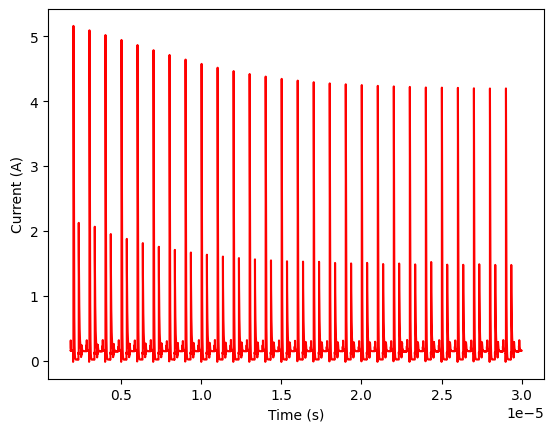

In [3]:
#https://stackoverflow.com/questions/46614526/how-to-import-a-csv-file-into-a-data-array
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.signal import find_peaks

df=pd.read_fwf('core_nofilter_constantload_POST.txt')
df.to_csv('core_nofilter_constantload_POST.csv', index=False)
data = pd.read_csv('core_nofilter_constantload_POST.csv').values



i_cut = 2000
i=0
pk_init = 10

#ls_current=[] max 5, mean 5, max 1.8, mean 1.8


flag=True
for number in data:
    if flag:
        row1=i+i_cut
        flag=False
    if round(number[0],13)==0.00003:
        row2=i
        i+=1
        break
    i+=1

y_out = data[row1:row2,1]
y_in = (-1)*data[row1:row2,3]
peaks , _ = find_peaks(y_in, height=0.7)
pk_len = len(peaks)
print('Peak length:',pk_len)
vout = np.mean(y_out[peaks[pk_init]:peaks[pk_len-1]])
iin = np.mean(y_in[peaks[pk_init]:peaks[pk_len-1]])
print('Output voltage:',vout,'V')
print('Input current:',iin,'A')
iout = round(big, 3)
pout = vout*iout
vin=5
pin = vin*iin
post_lay_sim_eff = (pout/pin)*(100)
print('Efficiency',post_lay_sim_eff)

plt.plot(data[row1:row2,0],y_in,color='r',label='In Current 5V')
plt.ylabel('Current (A)')
plt.xlabel('Time (s)')
plt.show()

In [14]:
from tabulate import tabulate
data = [["Efficiency", interpol_eff, pre_lay_dev_eff, post_lay_dev_eff, pre_layout_sim_eff, post_lay_sim_eff]]
  
#define header names
col_names = ["", "Interpolated", "Pre-Layout (Device Estimation)", "Post-Layout (Device Estimation)","Pre-Layout", "Post-Layout"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒════════════╤════════════════╤══════════════════════════════════╤═══════════════════════════════════╤══════════════╤═══════════════╕
│            │   Interpolated │   Pre-Layout (Device Estimation) │   Post-Layout (Device Estimation) │   Pre-Layout │   Post-Layout │
╞════════════╪════════════════╪══════════════════════════════════╪═══════════════════════════════════╪══════════════╪═══════════════╡
│ Efficiency │         89.248 │                          96.6175 │                                 0 │      93.5119 │             0 │
╘════════════╧════════════════╧══════════════════════════════════╧═══════════════════════════════════╧══════════════╧═══════════════╛
